In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def sep():
    print("\n" + "-"*50 + "\n")

def pretty(x):
    print('\n'.join(['\t'.join([str(cell) for cell in row]) for row in x]))

In [179]:
A = np.random.randint(0, 5, size=(6, 6))
pretty(A)

3	3	0	1	1	3
4	4	4	2	3	4
3	2	4	3	2	3
3	3	0	3	3	2
4	0	3	4	2	3
2	1	1	1	1	3


In [171]:
kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
print("Kernel:")
pretty(kernel)

Kernel:
1	1	1
1	1	1
1	1	1


In [178]:
def conv2d(A, kernel):
    n, A_row, A_col = A.shape  # n is the number of images, A_row is height, A_col is width
    kernel_row, kernel_col = kernel.shape
    result = np.zeros((n, A_row - kernel_row + 1, A_col - kernel_col + 1))

    # Iterate over each image in the batch
    for img in range(n):
        for i in range(result.shape[1]):  # Iterate over height
            for j in range(result.shape[2]):  # Iterate over width
                result[img, i, j] = np.sum(A[img, i:i+kernel_row, j:j+kernel_col] * kernel)

    return result


In [173]:
def pad(matrix, padding_size):
    original_rows, original_cols = matrix.shape

    # Create a new matrix filled with zeros, large enough to include the padding
    padded_matrix = np.zeros((original_rows + 2 * padding_size, original_cols + 2 * padding_size))
    
    # Place the original matrix into the center of the padded matrix
    padded_matrix[padding_size:-padding_size, padding_size:-padding_size] = matrix
    
    # Return the padded matrix
    return padded_matrix


In [180]:
A = pad(A, 1)
# add extra dimenion to A
A = A[np.newaxis, :, :]
sep()
print(conv2d(A, kernel))


--------------------------------------------------

[[[14. 18. 14. 11. 14. 11.]
  [19. 27. 23. 20. 22. 16.]
  [19. 27. 25. 24. 25. 17.]
  [15. 22. 22. 24. 25. 15.]
  [13. 17. 16. 18. 22. 14.]
  [ 7. 11. 10. 12. 14.  9.]]]


In [164]:
class ConvolutionLayer:
    def __init__(self, kernel_size, num_filters):
        self.kernel_size = kernel_size
        self.num_filters = num_filters
        self.filters = np.random.randn(num_filters, kernel_size, kernel_size) / (kernel_size * kernel_size)

    def generate_patches(self, A):
        A_row, A_col = A.shape
        for i in range(A_row - self.kernel_size + 1):
            for j in range(A_col - self.kernel_size + 1):
                patch = A[i : i + self.kernel_size, j : j + self.kernel_size]
                yield patch, i, j
    
    def forward(self, A):
        A_row, A_col = A.shape
        output = np.zeros((A_row - self.kernel_size + 1, A_col - self.kernel_size + 1, self.num_filters))

        for patch, i, j in self.generate_patches(A):
            output[i, j] = np.sum(patch * self.filters, axis=(1, 2))
        
        return output

In [165]:
cnn_layer = ConvolutionLayer(3, 2)
print(cnn_layer.filters.shape)
print(cnn_layer.filters)
sep()

patches = cnn_layer.generate_patches(A)
print(next(patches))
sep()

output = cnn_layer.forward(A)
print(output.shape)
print(output[:, :, 0])
sep()

(2, 3, 3)
[[[ 0.04515109 -0.10841757 -0.08616797]
  [-0.26473189  0.25545729 -0.00646385]
  [ 0.02812804 -0.22627443  0.16002924]]

 [[ 0.02436573  0.0152732   0.11129843]
  [-0.05896405 -0.11058799  0.32046785]
  [ 0.05466161  0.00526428 -0.05081055]]]

--------------------------------------------------

(array([[0., 0., 0.],
       [0., 2., 4.],
       [0., 0., 4.]]), 0, 0)

--------------------------------------------------

(6, 6, 2)
[[ 1.12517616  0.06735538 -0.99158558 -0.11102399  0.48498922 -0.40526314]
 [-0.87988201  0.6490804  -0.42212105  0.42339752 -1.30365518 -1.32893258]
 [-0.58528961 -0.76634831 -0.92301563 -0.15093514 -0.06607898 -0.23224254]
 [ 0.25981334 -0.54436675  0.05042583 -0.61101575 -0.29176    -1.39657289]
 [-0.36768848 -0.53061763  0.18382334 -0.25309648 -0.22099721 -1.26841175]
 [ 0.53660903 -0.38470637 -0.17165451 -0.52488399 -0.31392591 -0.07332916]]

--------------------------------------------------



In [193]:
class MaxPool2d:
    def __init__(self, pool_size):
        self.pool_size = pool_size
    
    def generate_patches(self, A):
        A_row, A_col, num_filters = A.shape
        for i in range(0, A_row, self.pool_size):
            for j in range(0, A_col, self.pool_size):
                patch = A[i : i+  self.pool_size, j : j + self.pool_size]
                yield patch, i, j
    
    def forward(self, A):
        self.last_input = A
        A_row, A_col, num_filters = A.shape
        output = np.zeros((A_row // self.pool_size, A_col // self.pool_size, num_filters))

        for patch, i, j in self.generate_patches(A):
            output[i//self.pool_size, j//self.pool_size] = np.amax(patch, axis=(0, 1))
        
        return output
    
    def backprop(self, d_loss_d_output):
        d_loss_d_input = np.zeros(self.last_input.shape)

        # Iterate over the regions as in forward pass
        for patch, row, col in self.generate_patches(self.last_input):
            patch_height, patch_width, num_channels = patch.shape
            max_values = np.amax(patch, axis=(0, 1))

            for i in range(patch_height):
                for j in range(patch_width):
                    for channel in range(num_channels):
                        # Find the pizel that was the max value in this patch, and pass the gradient back to it
                        if patch[i, j, channel] == max_values[channel]:
                            d_loss_d_input[row + i, col + j, channel] = d_loss_d_output[row // self.pool_size, col // self.pool_size, channel]
        
        return d_loss_d_input


In [167]:
max_pool = MaxPool2d(2)
output = max_pool.forward(output)
print(output.shape)
print(output[:, :, 0])

(3, 3, 2)
[[ 1.12517616  0.42339752  0.48498922]
 [ 0.25981334  0.05042583 -0.06607898]
 [ 0.53660903  0.18382334 -0.07332916]]


In [205]:
class LinearLayer:
    def __init__(self, num_inputs, num_outputs):
        self.weights = np.random.randn(num_inputs, num_outputs) / num_inputs
        self.bias = np.zeros(num_outputs)
    
    def softmax(self, A):
        expA = np.exp(A)
        return expA / expA.sum(axis=0)

    def forward(self, A):
        self.shape_before_flattening = A.shape
        A = A.flatten()
        self.input_to_last_layer = A
        input_size, output_size = self.weights.shape
        self.logits = np.dot(A, self.weights) + self.bias
        return self.softmax(self.logits)

    def backprop(self, y, y_hat, learn_rate):
        # Calculate the gradient of the loss w.r.t. the output (logits)
        correct_label = np.argmax(y)
        dLoss_dLogits = np.zeros(y_hat.shape)
        dLoss_dLogits[correct_label] = -1 / y_hat[correct_label]

        # e^totals and their sum (softmax layer backprop)
        t_exp = np.exp(self.logits)
        S = np.sum(t_exp)

        # Gradients of out[correct_label] against totals (we only need one element)
        d_out_d_t = -t_exp[correct_label] * t_exp / (S ** 2)
        d_out_d_t[correct_label] = t_exp[correct_label] * (S - t_exp[correct_label]) / (S ** 2)

        # Gradients of totals against weights/biases/input
        d_t_d_w = self.input_to_last_layer
        d_t_d_b = 1
        d_t_d_inputs = self.weights

        # Gradient of loss w.r.t. totals for the correct label
        d_L_d_t = dLoss_dLogits[correct_label] * d_out_d_t

        # Gradients of loss against weights/biases/input
        d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
        d_L_d_b = d_L_d_t * d_t_d_b
        d_L_d_inputs = d_t_d_inputs @ d_L_d_t

        # Update weights / biases
        self.weights -= learn_rate * d_L_d_w
        self.bias -= learn_rate * d_L_d_b

        return d_L_d_inputs.reshape(self.shape_before_flattening)


        

In [195]:
linear_layer = LinearLayer(18, 5)
output = linear_layer.forward(output)
print(output)

ValueError: shapes (5,) and (18,5) not aligned: 5 (dim 0) != 18 (dim 0)

In [196]:
mnist = pd.read_csv('mnist_train.csv')
mnist.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [321]:
data = mnist.values
split_index = int(0.8 * data.shape[0])
X = data[:1000, 1:].reshape(-1, 28, 28)
y = data[:1000, 0]

X_test = data[1500:2000, 1:].reshape(-1, 28, 28)
y_test = data[1500:2000, 0]

y_one_hot = np.zeros((y.shape[0], 10))
y_one_hot[np.arange(y.shape[0]), y] = 1


print(X.shape)
print(y_one_hot.shape)

print(X_test.shape)
print(y_test.shape)

print(X[0, 10:20, 10:20])

(1000, 28, 28)
(1000, 10)
(500, 28, 28)
(500,)
[[  1 154 253  90   0   0   0   0   0   0]
 [  0 139 253 190   2   0   0   0   0   0]
 [  0  11 190 253  70   0   0   0   0   0]
 [  0   0  35 241 225 160 108   1   0   0]
 [  0   0   0  81 240 253 253 119  25   0]
 [  0   0   0   0  45 186 253 253 150  27]
 [  0   0   0   0   0  16  93 252 253 187]
 [  0   0   0   0   0   0   0 249 253 249]
 [  0   0   0   0  46 130 183 253 253 207]
 [  0   0  39 148 229 253 253 253 250 182]]


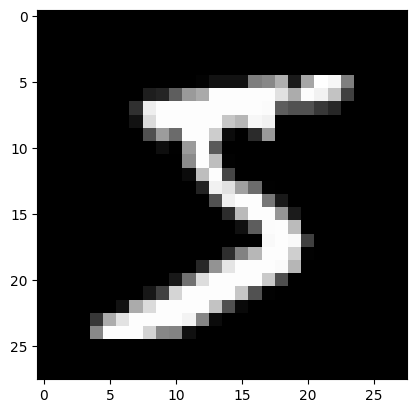

In [250]:
def show_img(img):
    plt.imshow(img, cmap='gray')
    plt.show()

show_img(X[0])

In [257]:
class CNN:
    def __init__(self, num_classes, lr=0.01):
        self.conv = ConvolutionLayer(3, 8)
        self.pool = MaxPool2d(2)
        # self.linear = LinearLayer(13 * 13 * 8, num_classes)
        self.linear = LinearLayer(14 * 14 * 8, num_classes)
        
    
    def forward(self, A):
        output = self.conv.forward(A)
        # print("After Convolution Layer:")
        # print(output.shape)
        # sep()

        output = self.pool.forward(output)
        # print("After Max Pooling Layer:")
        # print(output.shape)
        # sep()
        
        output = self.linear.forward(output)
        # print("After Linear Layer:")
        # print(output.shape)
        
        return output

### How is it 13x13x8?

Input was an image of size 28x28
Now, we have a kernel size of 3 x 3, so we will end up with a 28 - 3 + 1 = 26 x 26 image.
Since we have 8 filters, we will end up with 26 x 26 x 8 image after the first convolutional layer.

Now, we have a max pooling layer with a pool size of 2 x 2, so each block of 2 x 2 pixels will be reduced to 1 pixel. So, we will end up with a 13 x 13 x 8 image after the first max pooling layer.

In [326]:
cnn = CNN(10)

(10,)
3


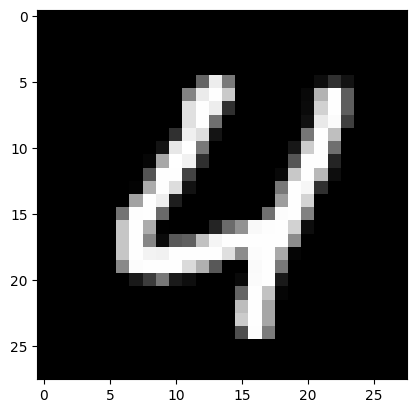

In [327]:
random_index = np.random.randint(0, X.shape[0])
inp = pad(X[random_index], 1)
inp = normalize(inp)

output = cnn.forward(inp)
print(output.shape)
print(np.argmax(output))
show_img(X[random_index])

In [328]:
def cross_entropy_loss(y, y_hat):
    return -np.sum(y * np.log(y_hat))

In [329]:
def testing_accuracy():
    correct = 0
    for i in range(X_test.shape[0]):
        inp = pad(X_test[i], 1)
        inp = normalize(inp)
        output = cnn.forward(inp)
        if np.argmax(output) == y_test[i]:
            correct += 1
    return correct / X.shape[0]

In [330]:
def train(im, label, lr=.005):
    # Forward
    out = cnn.forward(im)
    loss = cross_entropy_loss(label, out)
    gradient_back_from_linear = cnn.linear.backprop(label, out, lr)
    gradient_back_from_pool = cnn.pool.backprop(gradient_back_from_linear)
    return loss

In [331]:
for epoch in range(100):
    epoch_loss = 0
    for i in range(X.shape[0]):
        inp = pad(X[i], 1)
        inp = normalize(inp)
        loss = train(inp, y_one_hot[i])
        epoch_loss += loss
    
    print(f"Epoch {epoch + 1}, Loss: {epoch_loss / X.shape[0]}, Accuracy: {testing_accuracy()}")

Epoch 1, Loss: 1.9730808305306915, Accuracy: 0.358
Epoch 2, Loss: 1.4674612680764163, Accuracy: 0.398
Epoch 3, Loss: 1.173775602256474, Accuracy: 0.413
Epoch 4, Loss: 0.9932109602125951, Accuracy: 0.419


KeyboardInterrupt: 